# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [53]:
#Name
ModelName = 'titanic_propensity_survive'

#Setting the model target variable name
VarTarget = 'Survived'
VarId = 'PassengerId'
VarDate = 'ReferenceDate' 

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

CAT = ['Pclass'
,'Embarked'
,'cabine_prefix'
,'Ticket_str'
,'NameTitle']

# #float
NUM = ['Fare'
,'SibSp'
,'Parch'
,'Age_Mean'
,'Ticket_int']

#float
selected_features = CAT + NUM

# 2. Import Libraries

In [43]:
# !pip -q install -r requirements.txt

In [1]:
try:
    import sys
    sys.path.append('/anaconda/envs/azureml_py38/lib/python3.8/site-packages')    
except:
    pass

In [45]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [46]:
dataprep_df_full = pd.read_csv('./titanic/dataprep_df.csv')

In [47]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [48]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(int)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

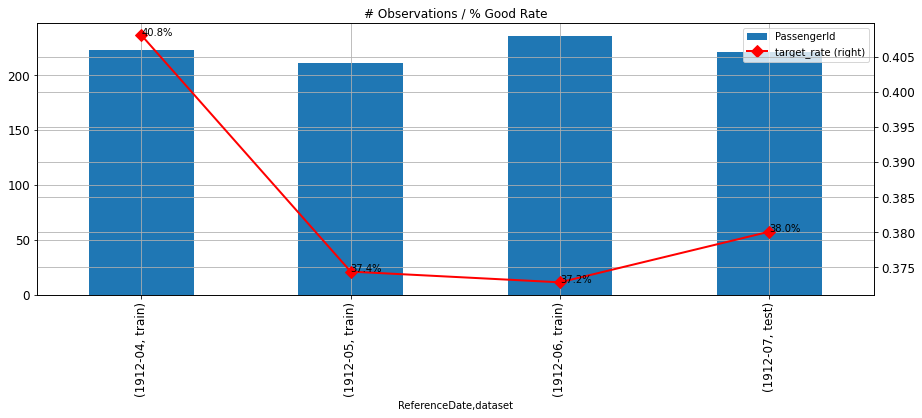

In [49]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]

dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [50]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [51]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [52]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 H2O AutoML

## 4.1.1 Creating context and H2O and Importing data into the H2O context

In [13]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpovcst08j
  JVM stdout: /tmp/tmpovcst08j/h2o_azureuser_started_from_python.out
  JVM stderr: /tmp/tmpovcst08j/h2o_azureuser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 25 days !!!
H2O_cluster_name:,H2O_from_python_azureuser_dp2y2u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.73 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


In [14]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 606
Validation: 64


In [15]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 221


## 4.1.2 Using H2O AutoML to performe all algorithms

In [16]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
20:03:52.303: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:03.320076



In [19]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
# print(lb.head(rows=lb.nrows))

In [20]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    # print(best_AutoML)

In [ ]:
# explain_model = best_AutoML.explain(frame=test_hdf, figsize=(8, 6))

## 4.2 PyTorch

In [54]:
normalized = []
for i in dataprep_df.columns:
    if (i.startswith('normalized_')):
        normalized.append(i)

dummy = []
for i in dataprep_df.columns:
    if (i.startswith('dummy_')):
        dummy.append(i)

In [71]:
# dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])]
# dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])]

x_train = dataprep_df.query('dataset == "train"').loc[:, (dummy)].to_numpy()
x_test = dataprep_df.query('dataset == "test"').loc[:, (dummy)].to_numpy()

y_train = dataprep_df.query('dataset == "train"').loc[:, (VarTarget)].values
y_test = dataprep_df.query('dataset == "test"').loc[:, (VarTarget)].values

In [75]:
X_train = dataprep_df.query('dataset == "train"').loc[:, (CAT)].values
Y_train = dataprep_df.query('dataset == "train"').loc[:, (VarTarget)].values
X_test = dataprep_df.query('dataset == "test"').loc[:, (CAT)].values

In [76]:
# Converting the remaining labels to numbers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X_train[:, 1] = labelencoder_X_1.fit_transform(X_train[:, 1])
X_train[:, 4] = labelencoder_X_1.fit_transform(X_train[:, 4])
X_train[:, 5] = labelencoder_X_1.fit_transform(X_train[:, 5])
X_train[:, 6] = labelencoder_X_1.fit_transform(X_train[:, 6])

labelencoder_X_2 = LabelEncoder()
X_test[:, 1] = labelencoder_X_2.fit_transform(X_test[:, 1])
X_test[:, 4] = labelencoder_X_2.fit_transform(X_test[:, 4])
X_test[:, 5] = labelencoder_X_2.fit_transform(X_test[:, 5])
X_test[:, 6] = labelencoder_X_2.fit_transform(X_test[:, 6])

IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
# Converting categorical values to one-hot representation
one_hot_encoder = OneHotEncoder(categorical_features = [0, 1, 4, 5, 6])
X_train = one_hot_encoder.fit_transform(X_train).toarray()
X_test = one_hot_encoder.fit_transform(X_test).toarray()

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.1)

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(19, 270)
        self.fc2 = nn.Linear(270, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.1)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        return x
    
net = Net()

In [68]:
batch_size = 50
num_epochs = 50
learning_rate = 0.01
batch_no = len(dataprep_df.query('dataset == "train"')) // batch_size

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [72]:
from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    x_train, y_train = shuffle(x_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = net(x_var)
        loss =criterion(ypred_var, y_var)
        loss.backward()
        optimizer.step()

Epoch 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x41 and 19x270)

In [58]:
# dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget])]
# dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])]

In [ ]:
from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(num_epochs):
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
    x_train, y_train = shuffle(x_train, y_train)
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end]))
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = net(x_var)
        loss =criterion(ypred_var, y_var)
        loss.backward()
        optimizer.step()

## 4.3 Compare performance on the TEST dataset for all trained models

In [28]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [29]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


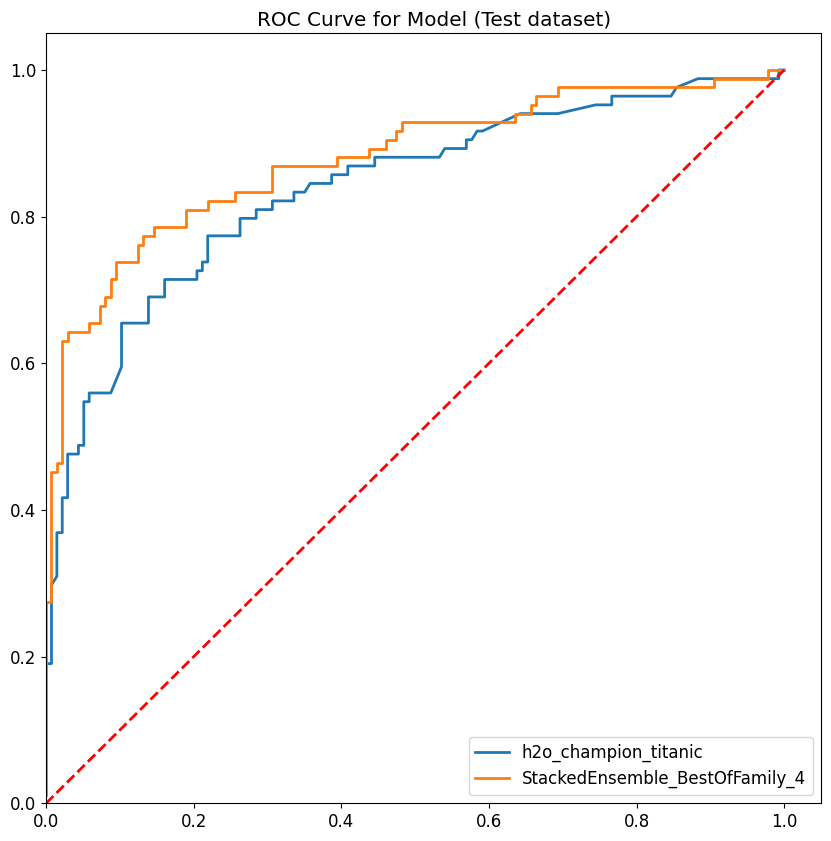

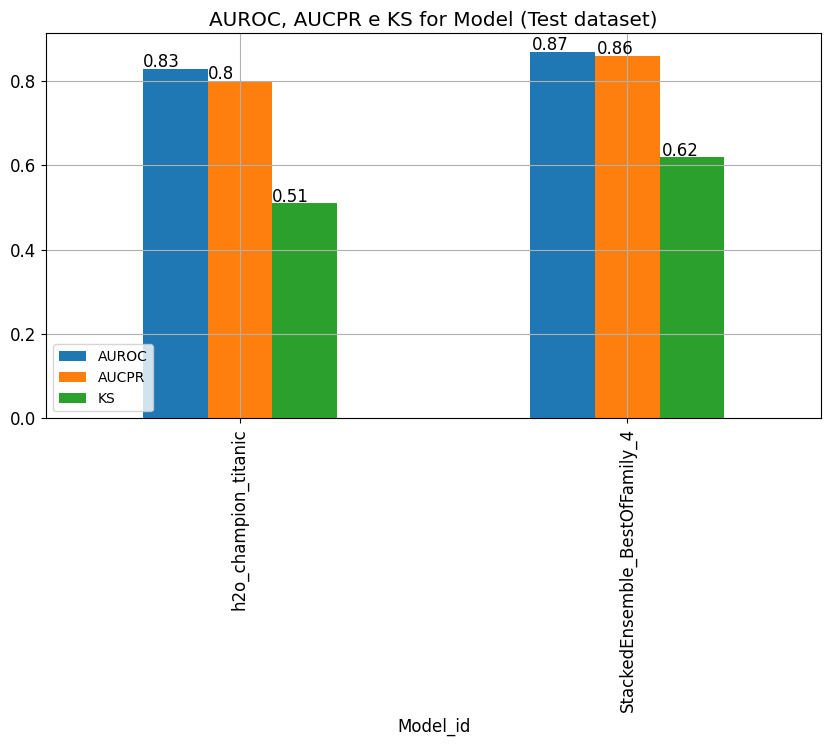

In [30]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('dataset == "test"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('dataset == "test"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [31]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,StackedEnsemble_BestOfFamily_4_AutoML_1_20221117_234854,0.652013,0.878693,0.862852,0.412667,0.625,0.445537
1,0,h2o_champion_titanic_propensity_survive_v1_20221117_234843,0.483557,0.839155,0.806852,0.483301,0.517,0.383971



BEST MODEL: h2o_champion_titanic_propensity_survive_v1_20221117_234843



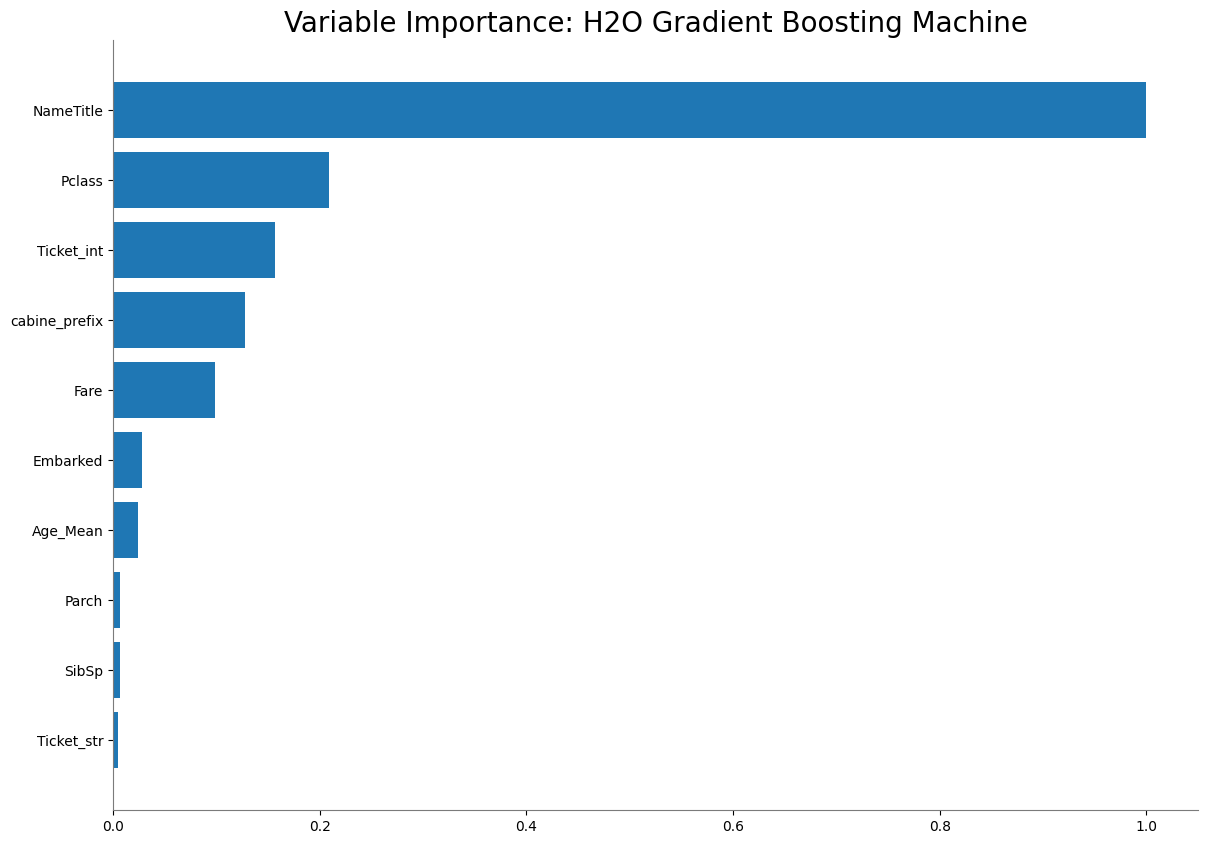

<Figure size 640x480 with 0 Axes>

In [33]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=1

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)    
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [34]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [35]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'testset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'testset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'testset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'testset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'testset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


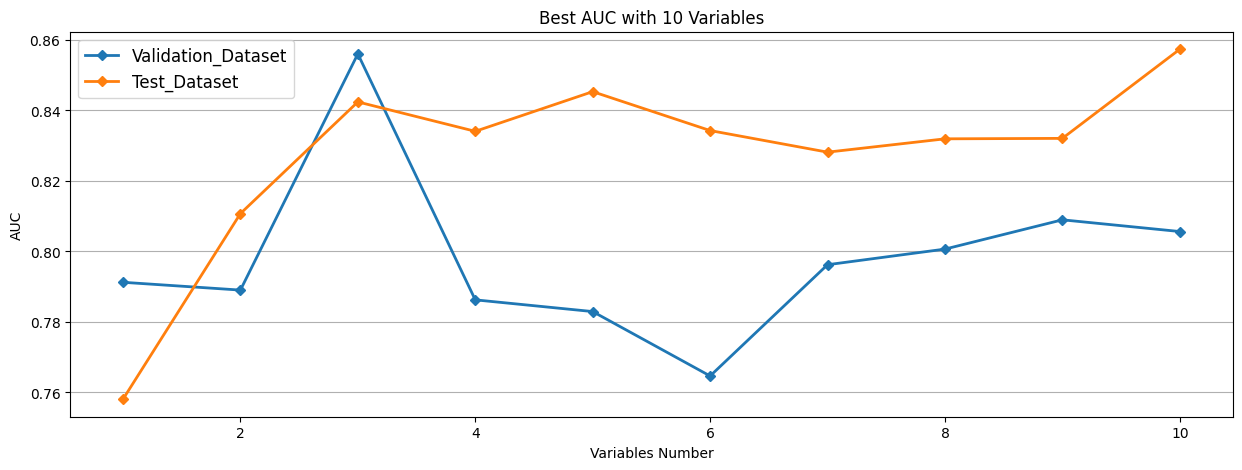

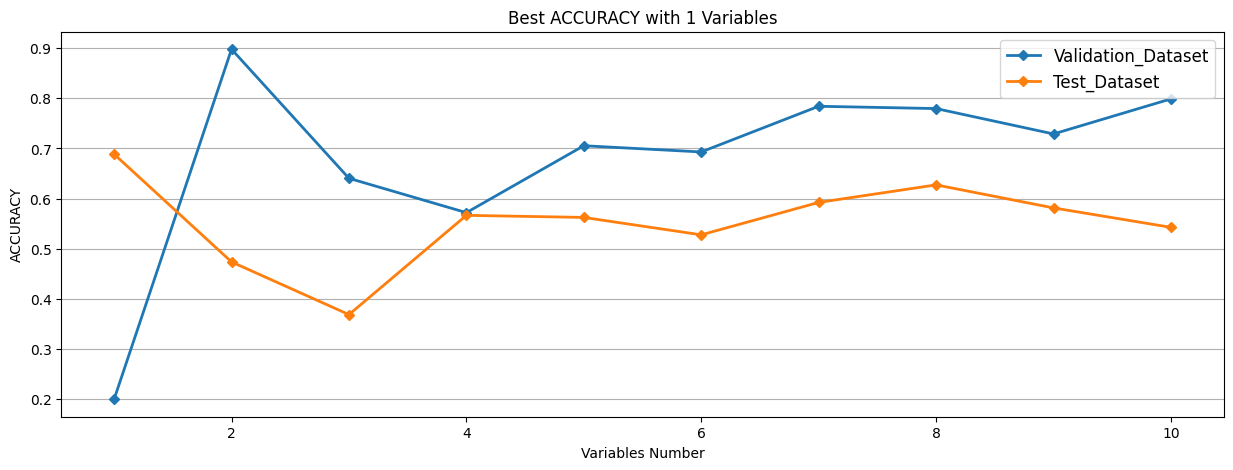

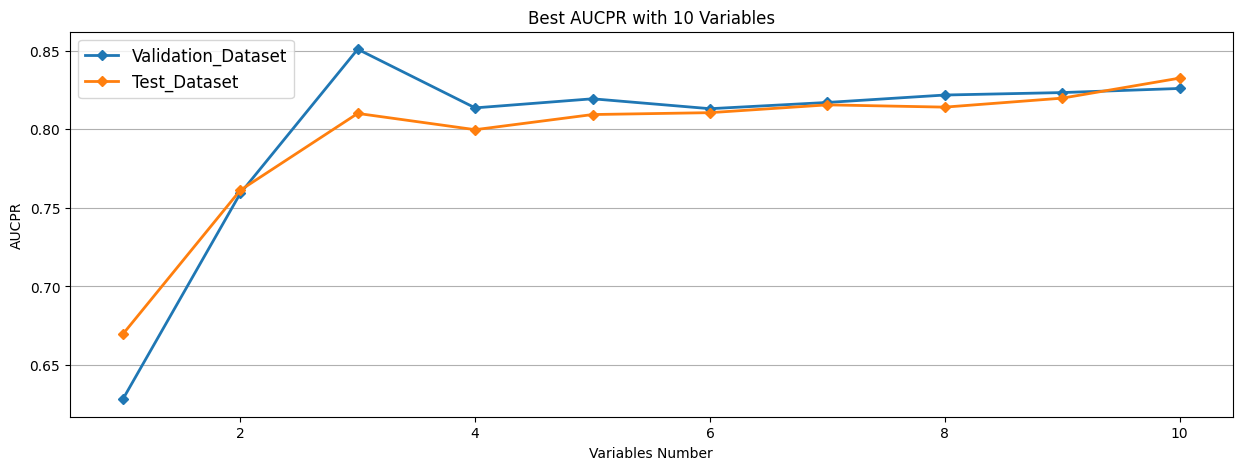

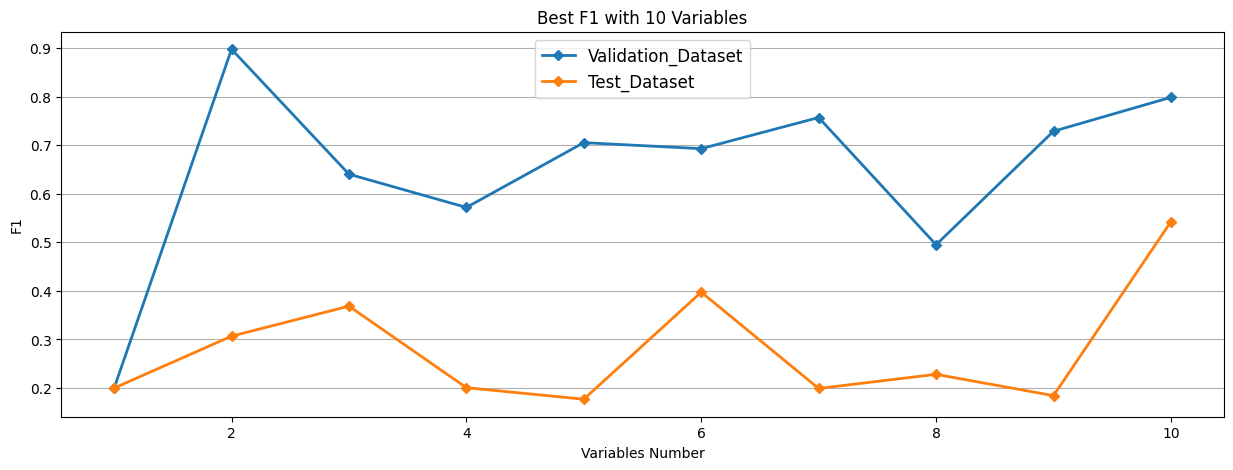

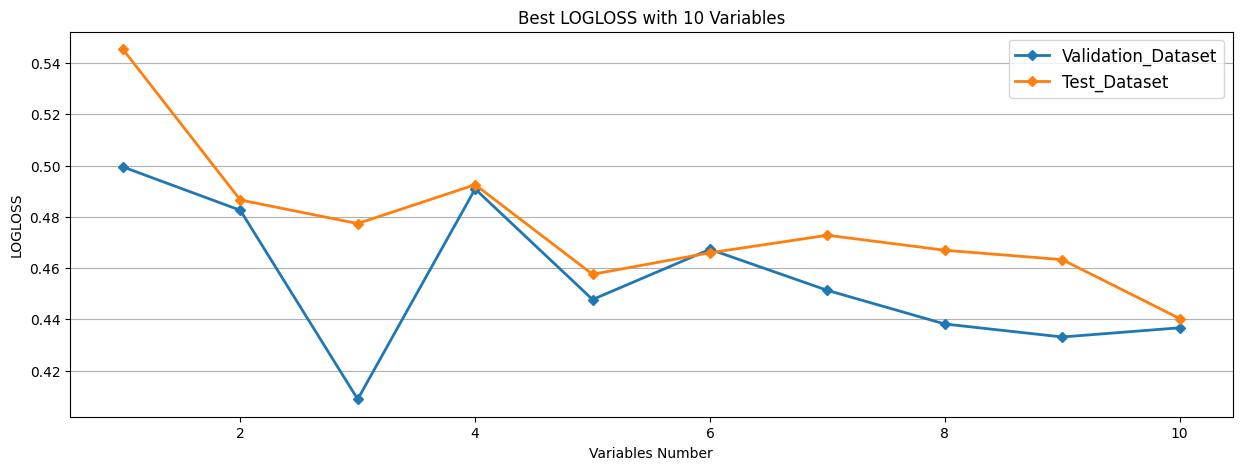

In [36]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['testset'] == metrics_df_tmp.testset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [38]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['NameTitle', 'Pclass', 'Ticket_int', 'cabine_prefix', 'Fare', 'Embarked', 'Age_Mean', 'Parch', 'SibSp', 'Ticket_str']


# 5. Exporting the best model to Deploy (Usar o path_model_mojo para o código 3_Explaining_Model.ipynb)

In [46]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    print(e)

path_model_mojo: /mnt/batch/tasks/shared/LS_root/mounts/clusters/maxdez1/code/Users/maxdez/FIEP-Machine-Learning-e-Computacao-em-Nuvem/output_model/models/best/h2o_champion_titanic_propensity_survive_v1_20221117_234843.zip


Detected 1 unused columns in the input data set: {}


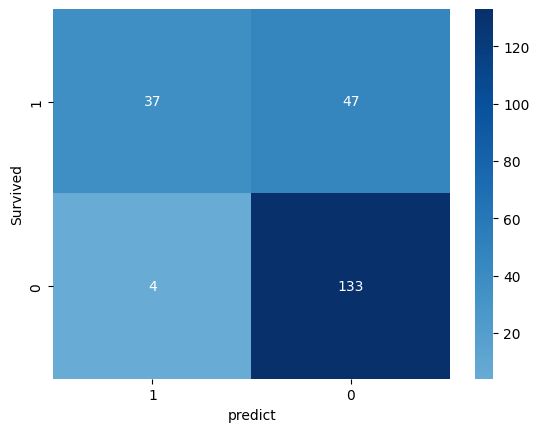

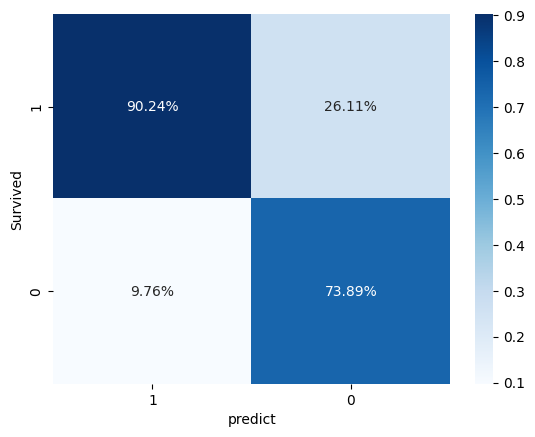

In [41]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

# 6. Save final dataset with predictions to CSV

In [45]:
df_predict.to_csv('./titanic/df_predict.csv', index=False, header=True)

In [13]:
import torch
dtype = torch.float
device = torch.device("cpu") # This executes all calculations on the CPU
# device = torch.device("cuda:0") # This executes all calculations on the GPU

In [3]:
# Creation of a tensor and filling of a tensor with random numbers
a = torch.randn(2, 3, device=device, dtype=dtype)
print(a) # Output of tensor A
# Output: tensor([[-1.1884,  0.8498, -1.7129],
#                  [-0.8816,  0.1944,  0.5847]])


tensor([[ 0.1709, -1.7416, -0.8526],
        [-0.8711,  2.4293, -2.4442]], device='cuda:0')


In [4]:

# Creation of a tensor and filling of a tensor with random numbers
b = torch.randn(2, 3, device=device, dtype=dtype)
print(b) # Output of tensor B
# Output: tensor([[ 0.7178, -0.8453, -1.3403],
#                  [ 1.3262,  1.1512, -1.7070]])

tensor([[ 1.0110,  0.0760,  0.3938],
        [ 0.4719, -1.3433,  1.2279]], device='cuda:0')


In [5]:

print(a*b) # Output of a multiplication of the two tensors
# Output: tensor([[-0.8530, -0.7183,  2.58],
#                  [-1.1692,  0.2238, -0.9981]])

tensor([[ 0.1728, -0.1324, -0.3358],
        [-0.4110, -3.2634, -3.0012]], device='cuda:0')


In [6]:

print(a.sum()) # Output of the sum of all elements in tensor A
# Output: tensor(-2.1540)


tensor(-3.3093, device='cuda:0')


In [7]:

print(a[1,2]) # Output of the element in the third column of the second row (zero based)
# Output: tensor(0.5847)

tensor(-2.4442, device='cuda:0')


In [8]:

print(a.max()) # Output of the maximum value in tensor A
# Output: tensor(-1.7129)

tensor(2.4293, device='cuda:0')


In [9]:
from torch import nn # Import the nn sub-module from PyTorch

In [14]:
class NeuralNetwork(nn.Module): # Neural networks are defined as classes
    def __init__(self): # Layers and variables are defined in the __init__ method
        super(NeuralNetwork, self).__init__() # Must be in every network.
        self.flatten = nn.Flatten() # Defining a flattening layer.
        self.linear_relu_stack = nn.Sequential( # Defining a stack of layers.
            nn.Linear(28*28, 512), # Linear Layers have an input and output shape
            nn.ReLU(), # ReLU is one of many activation functions provided by nn
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10), 
        )

    def forward(self, x): # This function defines the forward pass.
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
testar = NeuralNetwork()

In [16]:
testar.forward(a)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)